<a href="https://colab.research.google.com/github/ravindrabharathi/Project1/blob/master/session25/car_image_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Using GANs to generate Indian Car Images 

import necessary modules/libraries 

In [0]:
# example of a dcgan on cifar10
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

import numpy as np
import keras
import tensorflow as tf
from keras.layers import Input,Conv2D,MaxPooling2D,Flatten,Activation,BatchNormalization,UpSampling2D,Lambda
from keras.layers import Dropout,GlobalAveragePooling2D,LeakyReLU,Dense,Reshape, concatenate,Conv2DTranspose
from keras.models import Model,load_model
import matplotlib.pyplot as plt
#import keras.backend as K



import os
import time
from datetime import datetime


from keras.applications import InceptionResNetV2
from keras.callbacks import TensorBoard

from keras.optimizers import Adam
from keras.utils import to_categorical
from keras_preprocessing import image

from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed


import pandas as pd

import os

from matplotlib import pyplot

from numpy import load

from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam



### mount google drive from where we will load the car images for training 

In [13]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### get car images as a zip file and save them as a numpy array to be usd in training 

In [0]:
!cp './drive/My Drive/EVA/session25/car-images.zip' './'
!mkdir './data'


!unzip car-images.zip -d './data/'

### get a isting of the car image file names 

In [0]:
import os
images_list=os.listdir('./data/car-images')

### make sure we use only image files of jpeg type and don't process other hidden files from os 

In [0]:
for fname in images_list:
  if '.jpg' in fname:
    pass
  else:
    print(fname)
    images_list.remove(fname) 

### load the images to a numpy array

In [0]:


images=None
image_dir='./data/car-images/'

for i, image_path in enumerate(images_list):
  if (i<2000):
    if (i%100==0):
      print("processing image num "+str(i))
    try:
      # Load image
      loaded_image = image.load_img(image_dir+image_path, target_size=(100,100,3))

      # Convert PIL image to numpy ndarray
      loaded_image = image.img_to_array(loaded_image)

      # Add another dimension (Add batch dimension)
      loaded_image = np.expand_dims(loaded_image, axis=0)

      # Concatenate all images into one tensor
      if images is None:
        images = loaded_image
      else:
        images = np.concatenate([images, loaded_image], axis=0)
    except Exception as e:
      print("Error:", i, e)



### save numpy array to drive in order to use it on demand 

In [0]:
# save as compressed numpy array
filename = '/content/drive/My Drive/EVA/session25/cars_100.npz'
savez_compressed(filename, images)
print('Saved dataset: ', filename)

### load and plot some car images from the saved numpy array

Exception ignored in: <bound method NpzFile.__del__ of <numpy.lib.npyio.NpzFile object at 0x7fe5e0f43eb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 230, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 225, in close
    self.fid.close()
OSError: [Errno 107] Transport endpoint is not connected


Loaded:  (1042, 100, 100, 3)


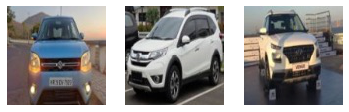

In [14]:
from numpy import load
from matplotlib import pyplot
# load the dataset
filename = '/content/drive/My Drive/EVA/session25/cars_100.npz'
data = load(filename)
dataA= data['arr_0']
print('Loaded: ', dataA.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(dataA[i].astype('uint8'))


### Discriminator model - takes 100x100x3 image as input and classified whether the image is a real car image or not 

The model has a sequence of convolution layers followed by a dense layer with sigmoid activation . The model is comiled with Adam optimizer and loss is binary-crossentropy 

In [0]:


# define the standalone discriminator model
def define_discriminator(in_shape=(100,100,3)):


	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
  # downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
  # downsample
	#model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	#model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	#model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model



function to pad a layer . used in last step of generator to get size 100

In [0]:
def padd2(input_):
  import tensorflow as tf
  return tf.pad(input_, [[0, 0], [2, 2], [2, 2], [0, 0]], "REFLECT") 

### Generator Model - Takes a latent vector (size 100- we could use a larger vector as refinement step) as input , which is reshaped to a 6x6 2d and a sequence of deconvolution layers upsample to 96x 96 .This is then followed by a reflect-pad of 2 on all sides to get 100x100

In [0]:
# define the standalone generator model
def define_generator(latent_dim):
  model = Sequential()
  # foundation for 4x4 image
  n_nodes = 256 * 6 * 6
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((6, 6, 256)))
  # upsample to 6
  model.add(Conv2DTranspose(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 12
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 24
  model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 48
  model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 96
  #model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
  #model.add(LeakyReLU(alpha=0.2))
  model.add(Lambda(padd2))
  # output layer
  model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
  return model



### Define GAN with discriminator and Generator as input

In [0]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model



### load real images from npz file to form the dataset for training

In [0]:
# load and prepare cifar10 training images
def load_real_samples():
	
	# convert from unsigned ints to floats
	X = dataA.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X



### function to generate real images - Real images are the ones we downloaded from internet and resized to 100x100 . 

In [0]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y



Fake image generation - Generate latent vectors of dim 100 and use them as input for generator to output fake images

In [0]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

function to save output images

In [0]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = '/content/drive/My Drive/EVA/session25/generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()


In [0]:
def save_plot2(step, g_model,latent_dim, n_samples=5):

	pyplot.figure(
    figsize=(15, 4),
    dpi=120)
 
	#generate images
	X_out, _ = generate_fake_samples(g_model,latent_dim, 5)
	# scale all pixels from [-1,1] to [0,1]
	
	X_out = (X_out + 1) / 2.0
	
	# plot images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '/content/drive/My Drive/EVA/session25/generated_plot_%06d.png' % ((step+1))
	pyplot.savefig(filename1)
	pyplot.close()

function to summarize how the models are performing - loss values for discriminator and generator 

In [0]:

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=250):
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print('epoch',(epoch+1),'>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
  save_plot2(epoch, g_model,latent_dim)
  # save the generator model tile file
  filename = '/content/drive/My Drive/EVA/session25/generator_model_%03d.h5' % (epoch+1)
  g_model.save(filename)
  filename2= '/content/drive/My Drive/EVA/session25/d_model_%03d.h5' % (epoch+1)
  d_model.save(filename2)


### define training params 

In [0]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model

In [0]:
d_model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 100, 100, 64)      1792      
_________________________________________________________________
leaky_re_lu_105 (LeakyReLU)  (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 50, 50, 128)       73856     
_________________________________________________________________
leaky_re_lu_106 (LeakyReLU)  (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 25, 25, 128)       147584    
_________________________________________________________________
leaky_re_lu_107 (LeakyReLU)  (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 13, 13, 256)     

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
g_model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 9216)              930816    
_________________________________________________________________
leaky_re_lu_110 (LeakyReLU)  (None, 9216)              0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_transpose_45 (Conv2DT (None, 12, 12, 128)       295040    
_________________________________________________________________
leaky_re_lu_111 (LeakyReLU)  (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_transpose_46 (Conv2DT (None, 24, 24, 128)       262272    
_________________________________________________________________
leaky_re_lu_112 (LeakyReLU)  (None, 24, 24, 128)     

### training function

In [0]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, start_epoch=0,end_epoch=200, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(start_epoch,end_epoch):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
		print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 50 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

initially train for 200 epochs 

In [0]:
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 8/8, d1=0.032, d2=0.807 g=0.700
>2, 8/8, d1=0.031, d2=0.585 g=0.856
>3, 8/8, d1=0.000, d2=0.096 g=2.918
>4, 8/8, d1=0.000, d2=0.000 g=8.083
>5, 8/8, d1=0.006, d2=0.019 g=4.944
>6, 8/8, d1=0.082, d2=0.000 g=16.118
>7, 8/8, d1=0.001, d2=0.000 g=16.118
>8, 8/8, d1=0.000, d2=0.000 g=16.118
>9, 8/8, d1=0.001, d2=0.000 g=16.118
>10, 8/8, d1=0.002, d2=0.000 g=16.118
>11, 8/8, d1=0.000, d2=0.000 g=16.118
>12, 8/8, d1=0.000, d2=0.000 g=16.118
>13, 8/8, d1=0.000, d2=0.000 g=16.118
>14, 8/8, d1=0.000, d2=0.000 g=16.118
>15, 8/8, d1=0.000, d2=0.000 g=16.118
>16, 8/8, d1=0.000, d2=0.000 g=16.118
>17, 8/8, d1=0.000, d2=0.000 g=16.115
>18, 8/8, d1=0.000, d2=0.554 g=5.350
>19, 8/8, d1=0.086, d2=0.047 g=3.247
>20, 8/8, d1=0.013, d2=0.013 g=5.379
>Accuracy real: 97%, fake: 100%
>21, 8/8, d1=0.000, d2=0.022 g=4.551
>22, 8/8, d1=0.158, d2=0.033 g=3.659
>23, 8/8, d1=0.066, d2=0.072 g=3.303
>24, 8/8, d1=0.325, d2=0.265 g=4.166
>25, 8/8, d1=0.056, d2=0.040 g=3.489
>26, 8/8, d1=0.135, d2=0.100 g=3.389
>27

train to 600 epochs

In [0]:
train(g_model, d_model, gan_model, dataset, latent_dim,start_epoch=200,end_epoch=600)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>201, 8/8, d1=0.443, d2=0.504 g=2.456
>202, 8/8, d1=0.524, d2=0.441 g=2.096
>203, 8/8, d1=0.460, d2=0.398 g=2.427
>204, 8/8, d1=0.567, d2=0.481 g=2.372
>205, 8/8, d1=0.615, d2=0.472 g=1.953
>206, 8/8, d1=0.344, d2=0.328 g=2.152
>207, 8/8, d1=0.488, d2=0.491 g=2.227
>208, 8/8, d1=0.313, d2=0.446 g=2.426
>209, 8/8, d1=0.440, d2=0.574 g=2.012
>210, 8/8, d1=0.422, d2=0.494 g=1.697
>211, 8/8, d1=0.422, d2=0.290 g=2.194
>212, 8/8, d1=0.422, d2=0.584 g=2.347
>213, 8/8, d1=0.416, d2=0.494 g=2.194
>214, 8/8, d1=0.419, d2=0.423 g=1.758
>215, 8/8, d1=0.487, d2=0.446 g=2.239
>216, 8/8, d1=0.414, d2=0.373 g=2.318
>217, 8/8, d1=0.396, d2=0.528 g=2.426
>218, 8/8, d1=0.530, d2=0.517 g=2.047
>219, 8/8, d1=0.301, d2=0.410 g=2.272
>220, 8/8, d1=0.552, d2=0.536 g=2.121
>Accuracy real: 83%, fake: 92%
>221, 8/8, d1=0.363, d2=0.340 g=1.808
>222, 8/8, d1=0.497, d2=0.362 g=2.253
>223, 8/8, d1=0.396, d2=0.344 g=2.049
>224, 8/8, d1=0.474, d2=0.583 g=2.330
>225, 8/8, d1=0.501, d2=0.598 g=2.443
>226, 8/8, d1=0.354

Check performance summary

In [0]:
summarize_performance(603, g_model, d_model, dataset, latent_dim)

>Accuracy real: 97%, fake: 99%


further training upto 1200 epochs 

In [0]:
train(g_model, d_model, gan_model, dataset, latent_dim,start_epoch=600,end_epoch=1200)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>Accuracy real: 100%, fake: 93%
>Accuracy real: 99%, fake: 99%
>Accuracy real: 99%, fake: 99%
>Accuracy real: 100%, fake: 100%
>Accuracy real: 100%, fake: 99%
>Accuracy real: 92%, fake: 99%
>Accuracy real: 100%, fake: 100%
>Accuracy real: 100%, fake: 100%
>Accuracy real: 98%, fake: 99%
>Accuracy real: 100%, fake: 98%
>Accuracy real: 100%, fake: 97%
>Accuracy real: 99%, fake: 100%


train upto 2000 epochs - this training loop was interrupted due to server disconnect and we hd to change accounts since the colab gpu server was blocked after long training run

In [0]:
train(g_model, d_model, gan_model, dataset, latent_dim,start_epoch=1200,end_epoch=2000)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch 1250 >Accuracy real: 100%, fake: 99%
epoch 1300 >Accuracy real: 100%, fake: 99%
epoch 1350 >Accuracy real: 100%, fake: 100%
epoch 1400 >Accuracy real: 100%, fake: 100%


### load models trained upto 1400 epochs in order to train them further 

In [0]:
# size of the latent space
latent_dim = 100
cust = {'tf': tf}
#load generator
g_model= load_model('/content/drive/My Drive/EVA/session25/generator_model_1400.h5', cust)
# load the discriminator
d_model = load_model('/content/drive/My Drive/EVA/session25/d_model_1400.h5', cust)

gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





### train to 2000 epochs - once again training was interrupted due to server disconnect

In [0]:
train(g_model, d_model, gan_model, dataset, latent_dim,start_epoch=1400,end_epoch=2000)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch 1450 >Accuracy real: 100%, fake: 99%
epoch 1500 >Accuracy real: 98%, fake: 99%
epoch 1550 >Accuracy real: 100%, fake: 98%
epoch 1600 >Accuracy real: 99%, fake: 100%
epoch 1650 >Accuracy real: 100%, fake: 98%
epoch 1700 >Accuracy real: 100%, fake: 100%
epoch 1750 >Accuracy real: 100%, fake: 99%


### load last saved model at epoch 1750 

In [30]:
# size of the latent space
latent_dim = 100
cust = {'tf': tf}
#load generator
g_model= load_model('/content/drive/My Drive/EVA/session25/generator_model_1750.h5', cust)
# load the discriminator
d_model = load_model('/content/drive/My Drive/EVA/session25/d_model_1750.h5', cust)

gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### Train to 3000 epochs - printing summary and saving generated image and models every 100 epochs . Here we noticed that at around 2300-2400 epochs the images started to degenerate implying collapse in training . This is also indicated by the several epochs that show 0 loss for both models 

In [31]:
train(g_model, d_model, gan_model, dataset, latent_dim,start_epoch=1750,end_epoch=3000)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1751, 8/8, d1=0.006, d2=0.029 g=11.883
>1752, 8/8, d1=0.016, d2=0.036 g=9.121
>1753, 8/8, d1=0.026, d2=0.030 g=9.427
>1754, 8/8, d1=0.024, d2=0.001 g=9.985
>1755, 8/8, d1=0.003, d2=0.001 g=11.027
>1756, 8/8, d1=0.005, d2=0.015 g=11.232
>1757, 8/8, d1=0.002, d2=0.011 g=10.675
>1758, 8/8, d1=0.017, d2=0.001 g=9.404
>1759, 8/8, d1=0.004, d2=0.036 g=11.248
>1760, 8/8, d1=0.007, d2=0.063 g=12.424
>1761, 8/8, d1=0.002, d2=0.007 g=9.995
>1762, 8/8, d1=0.003, d2=0.000 g=12.075
>1763, 8/8, d1=0.006, d2=0.004 g=9.709
>1764, 8/8, d1=0.015, d2=0.001 g=14.956
>1765, 8/8, d1=0.001, d2=0.000 g=11.534
>1766, 8/8, d1=0.002, d2=0.014 g=10.404
>1767, 8/8, d1=0.019, d2=0.082 g=12.154
>1768, 8/8, d1=0.001, d2=0.006 g=12.018
>1769, 8/8, d1=0.000, d2=0.052 g=14.019
>1770, 8/8, d1=0.001, d2=0.020 g=13.047
>1771, 8/8, d1=0.005, d2=0.001 g=9.120
>1772, 8/8, d1=0.014, d2=0.014 g=14.315
>1773, 8/8, d1=0.002, d2=0.000 g=12.306
>1774, 8/8, d1=0.002, d2=0.002 g=10.802
>1775, 8/8, d1=0.000, d2=0.001 g=10.880
>1776, 

In [52]:
# size of the latent space
latent_dim = 100
cust = {'tf': tf}
#load generator
g_model= load_model('/content/drive/My Drive/EVA/session25/generator_model_3000.h5', cust)
# load the discriminator
d_model = load_model('/content/drive/My Drive/EVA/session25/d_model_3000.h5', cust)

gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### function to plot generated images 

In [0]:
def print_plot2(step, g_model,latent_dim, n_samples=5):

	pyplot.figure(
    figsize=(15, 4),
    dpi=80)
 
	#generate images
	X_out, _ = generate_fake_samples(g_model,latent_dim, 5)
	# scale all pixels from [-1,1] to [0,1]
	
	X_out = (X_out + 1) / 2.0
	
	# plot images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	#filename1 = '/content/drive/My Drive/EVA/session25/generated_plot_%06d.png' % ((step+1))
	#pyplot.savefig(filename1)
	pyplot.show()

### load generated saved at epoch 2300 and plot some images 

In [79]:
g_model1= load_model('/content/drive/My Drive/EVA/session25/generator_model_2300.h5', cust)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


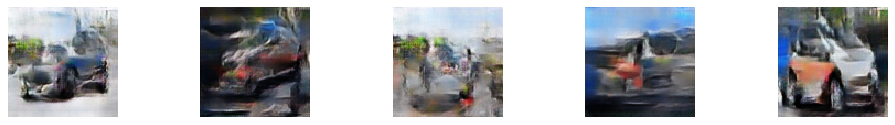

In [58]:
print_plot2(2301,g_model1,latent_dim,5)

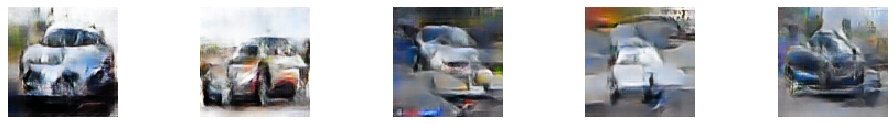

In [59]:
print_plot2(2302,g_model1,latent_dim,5)

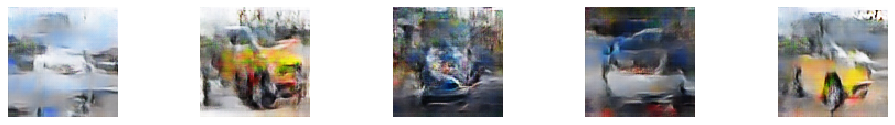

In [82]:
print_plot2(2301,g_model1,latent_dim,5)

### load generator model saved at epoch 2350 and plot some images 

In [83]:
g_model2= load_model('/content/drive/My Drive/EVA/session25/generator_model_2350.h5', cust)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


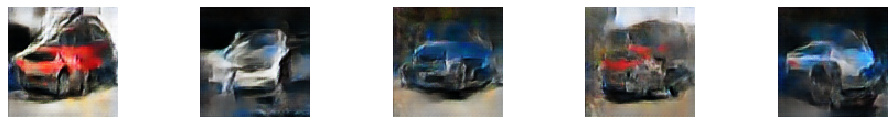

In [71]:
print_plot2(2201,g_model2,latent_dim,5)

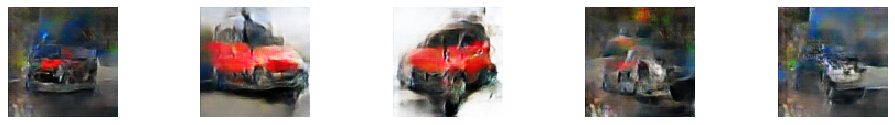

In [72]:
print_plot2(2301,g_model2,latent_dim,5)

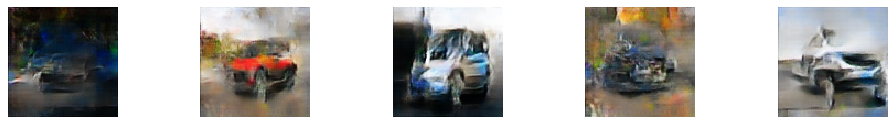

In [77]:
print_plot2(2301,g_model2,latent_dim,5)

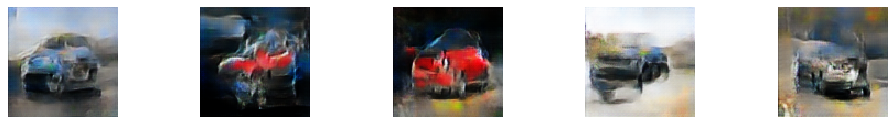

In [88]:
print_plot2(2301,g_model2,latent_dim,5)

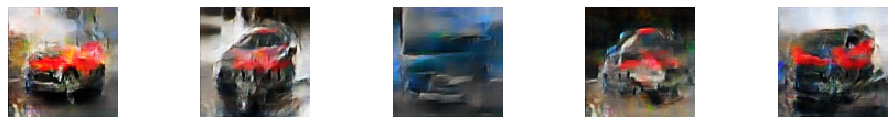

In [89]:
print_plot2(2301,g_model2,latent_dim,5)

### while the images seem to have some features of a car like wheels , a coloured metallic body, etc. , clearly they are not perfect. We have to revisit the model architecture and train the revised model from scratch to make improvements in image generation.

### Next steps - improve model by using a larger latent vector , better normalization of layers , etc